In [1]:
import imageio
import numpy as np
import cv2
import json
import torch
from scipy.spatial.transform import Rotation as scipy_rot
import sys
from torchvision.models import vgg16
from PIL import Image
from matplotlib import pyplot as plt
import itertools
import k3d

sys.path.append('../../old_code')

sys.path.append('/data/cornucopia/fml35/SuperPointPretrainedNetwork')


In [4]:
with open('/scratches/octopus_2/fml35/datasets/scannet/scan2cad_annotations/full_annotations.json') as json_file:
    all_data = json.load(json_file)

1506


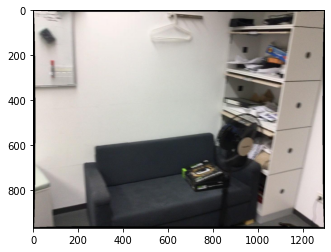

In [5]:
# dir_path = '/scratch2/fml35/datasets/scannet/scannet_frames_25k/'
dir_path = '/scratches/octopus_2/fml35/datasets/scannet/scannet_frames_25k/'

# for key in all_data[0]:
#     if key != 'aligned_models':
#         print(key)
#         print(all_data[0][key])

print(len(all_data))

for j in range(len(all_data)):
    if all_data[j]['id_scan'] == 'scene0025_01':
        break

scene_info = all_data[j]

frames = [str(100*i).zfill(6) for i in range(4,5)]
for frame in frames:
    im = cv2.imread(dir_path + scene_info['id_scan'] + '/color/' + frame + '.jpg')
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    fig = plt.figure()
    plt.imshow(im_rgb)
    plt.show()
    plt.close()

In [6]:
import os
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import shutil
from PIL import Image
import trimesh
import imagesize

import numpy as np

from tqdm import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj, load_obj
import pytorch3d

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PerspectiveCameras,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    Textures
)
from pytorch3d.renderer.blending import BlendParams,softmax_rgb_blend
# add path for demo utils functions 
import sys
import os

from PIL import Image


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [7]:

class myShader(torch.nn.Module):

    def __init__(
        self, device="cpu", cameras=None, blend_params=None
    ):
        super().__init__()
        self.cameras = cameras
        self.blend_params = blend_params if blend_params is not None else BlendParams()

    def forward(self, fragments, meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        if cameras is None:
            msg = "Cameras must be specified either at initialization \
                or in the forward pass of TexturedSoftPhongShader"
            raise ValueError(msg)
        # get renderer output
        blend_params = kwargs.get("blend_params", self.blend_params)
        texels = meshes.sample_textures(fragments)
        images = softmax_rgb_blend(texels, fragments, blend_params)

        return images

In [8]:
def make_M_from_tqs(t, q, s):
    # q = np.quaternion(q[0], q[1], q[2], q[3])
    T = np.eye(4)
    T[0:3, 3] = t
    R = np.eye(4)
    # R[0:3, 0:3] = quaternion.as_rotation_matrix(q)
    q = [q[1],q[2],q[3],q[0]]
    R[0:3, 0:3] = scipy_rot.from_quat(q).as_matrix()
    S = np.eye(4)
    S[0:3, 0:3] = np.diag(s)

    M = T.dot(R).dot(S)
    return M,R[0:3, 0:3],S[0:3, 0:3]

In [9]:

def load_4by4_from_txt(path):
    M = np.zeros((4,4))
    with open(path,'r') as f:
        content = f.readlines()
        for i in range(4):
            line = content[i].split()
            for j in range(4):
                M[i,j] = np.float32(line[j])
        return M


def create_setup(scene,frame):
    K = load_4by4_from_txt(dir_path + scene['id_scan'] + '/intrinsics_color.txt')

    width, height = imagesize.get(dir_path + scene['id_scan'] + '/color/{}.jpg'.format(frame))

    assert width >= height

    # w = K[0,2] * 2
    raster_settings = RasterizationSettings(image_size=width,blur_radius=0.0, faces_per_pixel=1)
    materials = Materials(device=device,specular_color=[[0.0, 0.0, 0.0]],shininess=1.0)

    focal_length = 2*K[0,0]/width
    ppoint = torch.Tensor([[width/2-K[0,2],height/2 - K[1,2]]])/ (width/2)
    # pose of camera from pose.txt file (assume this is in world coordinates)
    # https://github.com/ScanNet/ScanNet/blob/master/SensReader/c%2B%2B/README.txt this goes from camera to world coordinates
    # R_and_T = load_4by4_from_txt(dir_path + scene['id_scan'] + '/pose/' + frame + '.txt')
    # R_pose = R_and_T[:3,:3].copy()
    # T_pose = R_and_T[:3,3].copy()

    # T_pose = np.concatenate((T_pose,np.ones((1))),axis=0)
    

    # Mscene,_,_ = make_M_from_tqs(scene["trs"]['translation'],scene["trs"]['rotation'],scene["trs"]['scale'])

    # T_scene_pose = np.matmul(Mscene,T_pose)[:3]

    # R_scene_pose = np.matmul(Mscene[:3,:3],R_pose).copy()
    # R_scene_pose = np.linalg.inv(R_scene_pose)
    
    # T_final_pose = - np.matmul(R_scene_pose,T_scene_pose)
    # R_final_pose = np.linalg.inv(R_scene_pose)

    #TODO: HAVE pppoint at 0 at the moment
    #principal_point=ppoint

    # camera = PerspectiveCameras(device=device,focal_length=focal_length,principal_point=ppoint,T=torch.Tensor(T_final_pose).unsqueeze(0),R=torch.Tensor(R_final_pose).unsqueeze(0))
    r_cam = torch.eye(3).unsqueeze(0).repeat(1,1,1)
    t_cam = torch.zeros((1,3))
     
    print('f',focal_length,'r_cam',r_cam,'t_cam',t_cam,'ppoint',ppoint)
    print('w',width,'h',height)
    camera = PerspectiveCameras(device=device,focal_length=focal_length,principal_point=ppoint,T=t_cam,R=r_cam)

    rasterizer = MeshRasterizer(cameras=camera, raster_settings=raster_settings)
    renderer_textured = MeshRenderer(rasterizer=rasterizer,shader=myShader(device=device, cameras=camera))
    P_full = camera.get_full_projection_transform().get_matrix()
    P_proj = camera.get_projection_transform().get_matrix()
    return camera,rasterizer,renderer_textured,P_full,P_proj,width,height
    # return camera,rasterizer,renderer_textured,P_full,P_proj,width,height,r_cam[0],t_cam[0]


In [10]:
# translation from scan space to world space, think this is first transformation for camera, then apply camera pose
# camera,rasterizer,renderer_textured,P_full,P_proj = create_setup(scene_info,0)
print('---------')
camera,rasterizer,renderer_textured,P_full,P_proj,width,height = create_setup(scene_info,str(0).zfill(6))

---------
f 1.8049691282672646 r_cam tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]) t_cam tensor([[0., 0., 0.]]) ppoint tensor([[ 0.0026, -0.0091]])
w 1296 h 968


In [11]:
def get_scene_pose(frame_4by4_path,scene_trs):
    # R_and_T = load_4by4_from_txt(dir_path + scene['id_scan'] + '/pose/' + frame + '.txt')
    R_and_T = load_4by4_from_txt(frame_4by4_path)
    R_pose = R_and_T[:3,:3].copy()
    T_pose = R_and_T[:3,3].copy()

    T_pose = np.concatenate((T_pose,np.ones((1))),axis=0)
    

    # Mscene,_,_ = make_M_from_tqs(scene["trs"]['translation'],scene["trs"]['rotation'],scene["trs"]['scale'])
    Mscene,_,_ = make_M_from_tqs(scene_trs['translation'],scene_trs['rotation'],scene_trs['scale'])

    T_scene_pose = np.matmul(Mscene,T_pose)[:3]

    R_scene_pose = np.matmul(Mscene[:3,:3],R_pose).copy()
    R_scene_pose = np.linalg.inv(R_scene_pose)
    
    T_final_pose = - np.matmul(R_scene_pose,T_scene_pose)
    R_final_pose = np.linalg.inv(R_scene_pose)

    return R_scene_pose,T_final_pose

In [19]:
def create_all_meshes(R_scene_pose,T_scene_pose):
    shapenet_path = '/data/cvfs/fml35/derivative_datasets/shapenet_core_2/ShapeNetCore.v2/'
    # import quaternion
    all_vertices = []
    all_faces = []
    all_verts_rgb = []

    counter = 0
    for i in range(0,len(scene_info['aligned_models'])):
        model = scene_info['aligned_models'][i]
        vertices,faces,properties = load_obj('{}/{}/{}/models/model_normalized.obj'.format(shapenet_path,model['catid_cad'],model['id_cad']),device=device,create_texture_atlas=False, load_textures=False)

        t = model["trs"]["translation"]
        q = model["trs"]["rotation"]
        s = model["trs"]["scale"]
        Mcad,Rcad,Scad = make_M_from_tqs(t, q, s)
        
        # transform vertices according to cad model transformation

        # vertices = np.concatenate((np.array(vertices.cpu()),np.ones((vertices.shape[0],1))),axis=1)
        # vertices =  np.dot(Mcad,vertices.T).T
        # vertices_transformed = vertices[:,0:3]

        vertices = vertices.cpu().numpy()
        vertices_scaled = np.array(s) * vertices
        vertices =  np.matmul(Rcad,vertices_scaled.T).T + np.array(t)
        vertices_transformed = vertices[:,0:3]


        full_R = np.matmul(Rcad,Scad)

        full_T = np.array(t)

        vertices_transformed = np.matmul(R_scene_pose,vertices_transformed.T).T + T_scene_pose
        invert = torch.Tensor([[-1,0,0],[0,-1,0],[0,0,1.]])
        vertices_transformed = np.matmul(invert,vertices_transformed.T).T

        if 'edf13191dacf07af42d7295fb0533ac0' == model['id_cad']:
            print('verts',vertices[:2])
            print('verts transformed',vertices_transformed[:2])
            print('Rcad',Rcad)
            print('Scad',Scad)
            print('Tcad',t)
            print('Rscene',R_scene_pose)
            print('T',T_scene_pose)
            print(np.matmul(R_scene_pose,np.matmul(Rcad,Scad)))
        
        verts_rgb = torch.ones(vertices.shape[0],3) * i /len(scene_info['aligned_models'])
        
        all_vertices.append(vertices_transformed[:,:])
        all_faces.append(faces[0]+counter)
        all_verts_rgb.append(verts_rgb)

        counter += vertices.shape[0]


    vertices = np.concatenate(all_vertices,axis=0)
    all_faces = torch.cat(all_faces,dim=0)
    verts_rgb = torch.Tensor(np.concatenate(all_verts_rgb,axis=0)).unsqueeze(0)
    # verts_rgb = torch.ones((1,vertices.shape[0],3))*0.2
    textures = Textures(verts_rgb=verts_rgb.to(device))

    print(vertices.shape)
    print(all_faces.shape)

    # torch_vertices = [torch.Tensor(vertices).to(device) for vertices in all_vertices]

    meshes = Meshes(verts=[torch.Tensor(vertices).to(device)],faces=[all_faces],textures=textures)
    return meshes

000900
f 1.8049691282672646 r_cam tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]) t_cam tensor([[0., 0., 0.]]) ppoint tensor([[ 0.0026, -0.0091]])
w 1296 h 968
(21429, 3)
torch.Size([83154, 3])


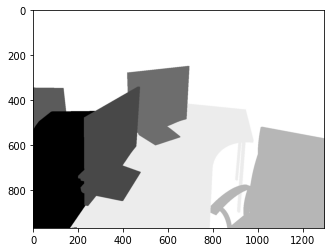

001000
f 1.8049691282672646 r_cam tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]) t_cam tensor([[0., 0., 0.]]) ppoint tensor([[ 0.0026, -0.0091]])
w 1296 h 968
(21429, 3)
torch.Size([83154, 3])


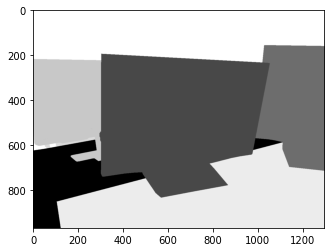

001100
f 1.8049691282672646 r_cam tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]) t_cam tensor([[0., 0., 0.]]) ppoint tensor([[ 0.0026, -0.0091]])
w 1296 h 968
(21429, 3)
torch.Size([83154, 3])


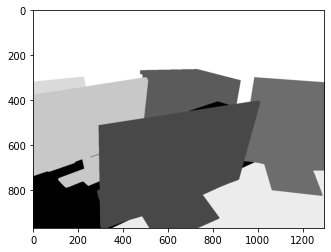

In [20]:
K = load_4by4_from_txt(dir_path + scene_info['id_scan'] + '/intrinsics_color.txt')
# h = K[1,2]*2
# w = K[0,2]*2
# diff = w - h

frames = [str(100*i).zfill(6) for i in range(9,12)]
for frame in frames:
    print(frame)
    camera,rasterizer,renderer_textured,P_full,P_proj,width,height = create_setup(scene_info,frame)
    frame_4by4_path = dir_path + scene_info['id_scan'] + '/pose/' + frame + '.txt'
    scene_trs = scene_info["trs"]
    R_scene_pose,T_scene_pose = get_scene_pose(frame_4by4_path,scene_trs)
    meshes = create_all_meshes(R_scene_pose,T_scene_pose)
    

    # VISUALISE 3D objects
    # verts_list = meshes.verts_list()
    # faces_list = meshes.faces_list()
    # plot = k3d.plot()

    # for i in range(len(verts_list)):
    #     plot += k3d.mesh(np.array(verts_list[i]),np.array(faces_list[i]),color=(64 + 128 * 256))

    # plot.display()

    


    images = renderer_textured(meshes)
    # print(images[images!=torch.Tensor([1.,1.,1.,0.]).to(device)])
    fig = plt.figure()
    image =images[0,:,:,:3].cpu().numpy()
    # flip
    # image = image[::-1,::-1,:]
    # crop
    diff = width-height
    image_cropped = image[int(diff/2):-int(diff/2),:,:]
    # print(np.max(image_cropped))
    # print(np.min(image_cropped))
    image_clipped = np.clip(0,1,image_cropped)
    [str(100*i).zfill(6) for i in range(7)]
    # plt.imsave('/data/cornucopia/fml35/test_renders/{}.jpg'.format(frame),image_clipped)
    plt.imshow(image_cropped)

    plt.show()
    plt.close()


In [ ]:
target = [[-0.8936729594926967, 0.040806766607977156, 0.4468595490319075], [-0.15854007905580134, -0.96034109813543, -0.22936784742036426], [0.41977701034708625, -0.2758254477494771, 0.8647005509063586]]